## Item Response Theory 

### 1. Kết nối cơ sở dữ liệu

In [1]:
import numpy as np
import pandas as pd
import torch
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

from girth.synthetic import create_synthetic_irt_dichotomous
from girth import twopl_mml, onepl_mml, rasch_mml, tag_missing_data


uri = "mongodb+srv://<username>:<password>@cluster0.jmil5cr.mongodb.net/" # Thay user, pass của mình vào  

# Connect to server
client = MongoClient(uri, server_api=ServerApi('1'))

# Check if the connection is successful
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)


db = client['dtu']
history = db["answered_questions"] # Collection contains the 100 most recent questions the player has played 

pipeline = [{"$unwind": "$questions"}, 
            {"$project": {"_id": 0, 
                          "player": "$playerId._id", 
                          "question": "$questions._id", 
                          "player_major": "$playerId.major", 
                          "player_rank": "$playerId.rank", 
                          "question_diff": "$questions.difficulty",
                          "question_category": "$questions.category",
                          "time": "$questions.timeForAnswer",
                          "status": "$questions.status"}}]

# Get data from DB
data = history.aggregate(pipeline) 

df = pd.DataFrame(list(history.aggregate(pipeline))) 

df_players_per_question = (
    df.groupby(["question"]).agg({"player": "nunique"}).reset_index()
)
df_players_per_question.columns = ["question", "num_of_players"]
df_players_per_question.head()

# Retrieve a list of questions that have more than n players (e.g: n = 2)
num_of_players_threshold = 2

mask = df_players_per_question["num_of_players"] >= num_of_players_threshold
valid_questions = set(df_players_per_question.loc[mask, "question"].tolist())

# filter invalid records
df_filter_ques = df[df["question"].isin(valid_questions)].copy()

Pinged your deployment. You successfully connected to MongoDB!


### 2. Ứng dụng Lý thuyết đáp ứng câu hỏi

Lọc ra xét trên nhóm người có cùng major. Trong thực hệ thống sẽ có bước phân cụm người chơi theo dữ liệu người dùng

In [2]:
major = df_filter_ques['player_major']
specific_player_major = major[999999]# Example values

# Create a boolean mask to filter rows where player_major matches the specific_player_major
mask = df_filter_ques['player_major'].apply(lambda x: set(x) == set(specific_player_major))

# Apply the mask to filter the DataFrame
filtered_df = df_filter_ques[mask].reset_index(drop=True)
filtered_df = filtered_df.head(1000)
filtered_df


,player,question,player_major,player_rank,question_diff,question_category,time,status
0,65fbfc409a31efcf7a3f9b7d,65fbf56a4dba71a085a1f202,"[Literature, Physics, His, Eng]",7,4,His,28,0
1,65fbfc409a31efcf7a3f9b7d,65fbf56a4dba71a085a1e347,"[Literature, Physics, His, Eng]",7,5,Eng,19,0
2,65fbfc409a31efcf7a3f9b7d,65fbfb83b5440169b33e133e,"[Literature, Physics, His, Eng]",7,1,Physics,28,0
3,65fbfc409a31efcf7a3f9b7d,65fbfb83b5440169b33e0b1b,"[Literature, Physics, His, Eng]",7,1,Eng,18,1
4,65fbfc409a31efcf7a3f9b7d,65fbf56a4dba71a085a1de47,"[Literature, Physics, His, Eng]",7,4,His,18,0
...,...,...,...,...,...,...,...,...
995,65fbfc419a31efcf7a3fb6ef,65fbfb83b5440169b33deeeb,"[Eng, His, Physics, Literature]",6,4,Literature,18,0
996,65fbfc419a31efcf7a3fb6ef,65fbf56a4dba71a085a1d56a,"[Eng, His, Physics, Literature]",6,5,His,17,0
997,65fbfc419a31efcf7a3fb6ef,65fbfb83b5440169b33dee42,"[Eng, His, Physics, Literature]",6,3,Literature,14,0
998,65fbfc419a31efcf7a3fb6ef,65fbfb83b5440169b33dfdee,"[Eng, His, Physics, Literature]",6,3,Physics,14,0


Lấy ra thông tin tương tác giữa người dùng và câu hỏi

In [5]:
unique_players = filtered_df["player"].unique()
player_ids = dict(
    zip(unique_players, np.arange(unique_players.shape[0])))

unique_questions = filtered_df["question"].unique()
question_ids = dict(
    zip(unique_questions, np.arange(unique_questions.shape[0])))

filtered_df["player_id"] = filtered_df["player"].apply(
    lambda i: player_ids[i]
)
filtered_df["question_id"] = filtered_df["question"].apply(
    lambda i: question_ids[i]
)

In [6]:
filtered_df

,player,question,player_major,player_rank,question_diff,question_category,time,status,player_id,question_id
0,65fbfc409a31efcf7a3f9b7d,65fbf56a4dba71a085a1f202,"[Literature, Physics, His, Eng]",7,4,His,28,0,0,0
1,65fbfc409a31efcf7a3f9b7d,65fbf56a4dba71a085a1e347,"[Literature, Physics, His, Eng]",7,5,Eng,19,0,0,1
2,65fbfc409a31efcf7a3f9b7d,65fbfb83b5440169b33e133e,"[Literature, Physics, His, Eng]",7,1,Physics,28,0,0,2
3,65fbfc409a31efcf7a3f9b7d,65fbfb83b5440169b33e0b1b,"[Literature, Physics, His, Eng]",7,1,Eng,18,1,0,3
4,65fbfc409a31efcf7a3f9b7d,65fbf56a4dba71a085a1de47,"[Literature, Physics, His, Eng]",7,4,His,18,0,0,4
...,...,...,...,...,...,...,...,...,...,...
995,65fbfc419a31efcf7a3fb6ef,65fbfb83b5440169b33deeeb,"[Eng, His, Physics, Literature]",6,4,Literature,18,0,9,962
996,65fbfc419a31efcf7a3fb6ef,65fbf56a4dba71a085a1d56a,"[Eng, His, Physics, Literature]",6,5,His,17,0,9,963
997,65fbfc419a31efcf7a3fb6ef,65fbfb83b5440169b33dee42,"[Eng, His, Physics, Literature]",6,3,Literature,14,0,9,964
998,65fbfc419a31efcf7a3fb6ef,65fbfb83b5440169b33dfdee,"[Eng, His, Physics, Literature]",6,3,Physics,14,0,9,965


In [7]:
interaction_df = filtered_df[["player_id", "question_id", "status"]].copy()
interaction_df

,player_id,question_id,status
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,1
4,0,4,0
...,...,...,...
995,9,962,0
996,9,963,0
997,9,964,0
998,9,965,0


In [10]:
len(unique_players)

10

Xây dựng ma trận tương tác. Người chơi trả lời đúng thì giá trị là 1, trả lời sai giá trị là 0, nếu chưa có tương tác thì giá trị là np.nan

In [11]:
num_player, num_ques = len(unique_players), len(unique_questions)
interaction_matrix = np.full((num_player, num_ques), np.nan)

for index, row in interaction_df.iterrows(): 
    player_id = row['player_id']
    question_id = row['question_id']
    status = row['status']
    interaction_matrix[player_id, question_id] = status 

print(interaction_matrix)

[[ 0.  0.  0. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ...  0.  0.  1.]]


Xử lý ma trận trên dùng lý thuyết đáp ứng câu hỏi

In [12]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
tagged_data = tag_missing_data(interaction_matrix, [0, 1]) 
print(tagged_data) 

[[ 0.0000e+00  0.0000e+00  0.0000e+00 ... -9.9999e+04 -9.9999e+04
  -9.9999e+04]
 [-9.9999e+04 -9.9999e+04 -9.9999e+04 ... -9.9999e+04 -9.9999e+04
  -9.9999e+04]
 [-9.9999e+04 -9.9999e+04 -9.9999e+04 ... -9.9999e+04 -9.9999e+04
  -9.9999e+04]
 ...
 [-9.9999e+04 -9.9999e+04 -9.9999e+04 ... -9.9999e+04 -9.9999e+04
  -9.9999e+04]
 [-9.9999e+04 -9.9999e+04 -9.9999e+04 ... -9.9999e+04 -9.9999e+04
  -9.9999e+04]
 [-9.9999e+04 -9.9999e+04 -9.9999e+04 ...  0.0000e+00  0.0000e+00
   1.0000e+00]]


In [14]:
estimates = rasch_mml(tagged_data)
difficulty_estimates = estimates['Difficulty']
difficulty_estimates

array([-0.04842329, -0.2427226 ,  0.19393184, -0.29764956,  0.04839038,
        0.14534082,  0.57142092,  0.22051166,  0.0249321 , -0.04842329])

In [15]:
def icc_1pl(theta, b):
    return 1 / (1 + np.exp(-(theta - b)))

def inf_1pl(p_theta):
    return p_theta * (1 - p_theta)

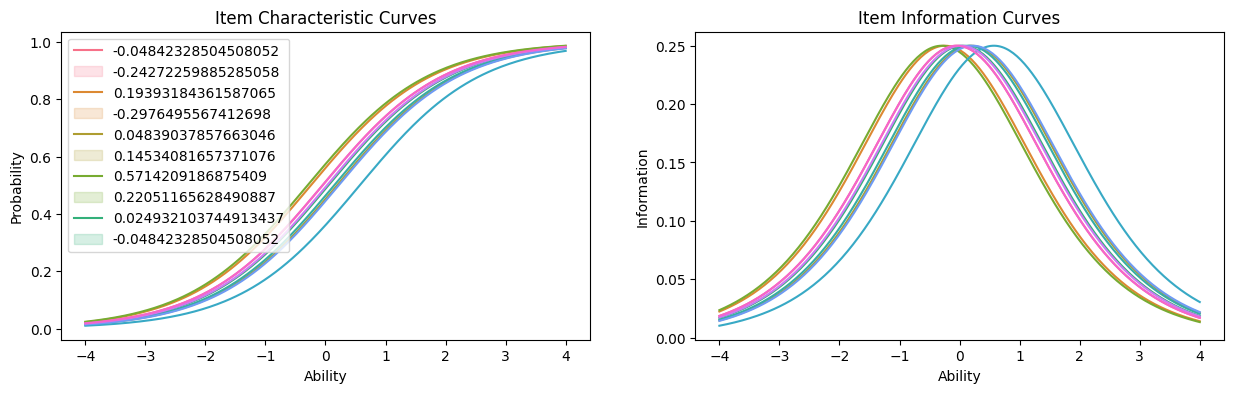

In [16]:
plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl", 10)
f, (ax1, ax2) = plt.subplots(1, 2) 

theta = np.linspace(-4, 4, 256, endpoint=True) 
for b in difficulty_estimates:
    p_theta = icc_1pl(theta, b) 
    sns.lineplot(x=theta, y=p_theta, ax=ax1)
    sns.lineplot(x=theta, y=inf_1pl(p_theta), ax=ax2)

ax1.set_title('Item Characteristic Curves')
ax1.set_xlabel('Ability')
ax1.set_ylabel('Probability')

ax2.set_title('Item Information Curves')
ax2.set_xlabel('Ability')
ax2.set_ylabel('Information')

ax1.legend(difficulty_estimates)

plt.show()